# Historical analysis of WeRateDogs tweets
by Charles Dellinger

In [1]:
# toggle button code from:
#     https://stackoverflow.com/a/28073228

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Data
The base data was gathered from the Twitter archive provided by the user. The names were scraped from the tweet text and the dog breeds from the pictures in the tweet using machine learning algorithms. Additional data, such as favorite count and retweet count were added through retrieval using the Tweepy API in Python.

### Analysis

In [2]:
# load libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
import seaborn as sns
from datetime import datetime, time

In [3]:
# load DataFrame
folder_name = 'project_data'
tweet_archive_master_name = 'twitter_archive_master.csv'
tweet_archive_master_path = os.path.join('..', folder_name, tweet_archive_master_name)
tweet_archive_master = pd.read_csv(tweet_archive_master_path)
tweet_archive_master.timestamp = pd.to_datetime(tweet_archive_master.timestamp, format = '%Y-%m-%d %H:%M:%S')

#### Tweet counts by month
Retweet count and favorite count of the WeRateDogs' tweets were chosen to gauge the popularity of the Twitter account over time. The more obvious follower count was not available in the archive and the API only supplied the followers at the time the information was pulled.

Below is the the graph of tweet count, favorite count, and retweet count over time summed by month.

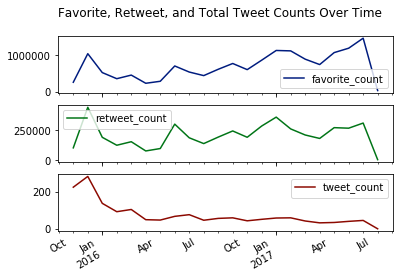

In [4]:
# isolate 'favorite_count', 'retweet_count', and group by month
tweet_counts_by_month = tweet_archive_master[['timestamp', 'favorite_count', 'retweet_count']].groupby(pd.Grouper(key='timestamp', freq='M')).sum()
# create total 'tweet_count' column with total tweet count per month
tweet_counts_by_month['tweet_count'] = tweet_archive_master[['timestamp', 'tweet_id']].groupby(pd.Grouper(key='timestamp', freq='M')).count()
# plot 'favorite_count', 'retweet_count', and 'tweet_count' grouped by month
tweet_counts_by_month.plot(subplots=True, title='Favorite, Retweet, and Total Tweet Counts Over Time',
                           use_index=True); plt.xlabel('');

Looking at the plot of tweet counts above, the favorite count and retweet count increased over time in general, but the bump in tweets at the beginning kind of hide this trend. The popularity of the Twitter account can be better visualized by isolating the favorite and retweet counts per tweet using the monthly totals.

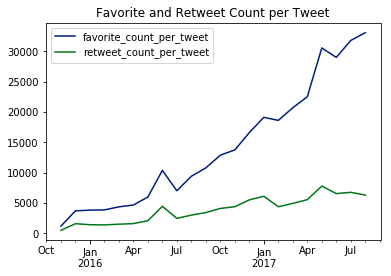

In [5]:
# create a favorite and retweet count per tweet DataFrame
per_tweet_archive_by_month = tweet_counts_by_month.copy()
# divide 'favorite_count' and 'retweet_count' by 'tweet_count' to get per tweet counts
per_tweet_archive_by_month['favorite_count'] /= per_tweet_archive_by_month['tweet_count']
per_tweet_archive_by_month['retweet_count'] /= per_tweet_archive_by_month['tweet_count']
# drop 'tweet_count'
per_tweet_archive_by_month.drop('tweet_count', axis=1, inplace=True)
# rename columns to '*_per_tweet'
per_tweet_archive_by_month.columns = ['favorite_count_per_tweet', 'retweet_count_per_tweet']
# plot
per_tweet_archive_by_month.plot(title='Favorite and Retweet Count per Tweet'); plt.xlabel('');

Looking at the trends over time, the favorite and retweet count clearly increased steadily. The favorite and retweet count may not be a direct measure of popularity of the Twitter account, but they should at least be partially indicative of a larger population following the account.

##### Tweet counts by hour of day

Similar to the tweet counts per month, the tweet time during the day may show that there is an influence on post time to repsonse. To examine that, the tweet counts were summed by hour of day.

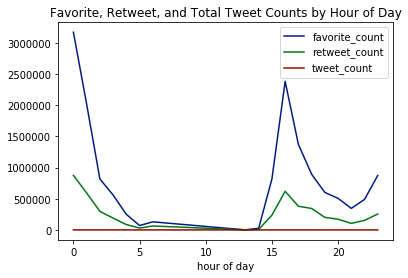

In [6]:
# copy 'timestamp', 'favorite_count', and 'retweet_count'
tweet_counts_by_hour = tweet_archive_master[['timestamp', 'favorite_count', 'retweet_count']].copy()
# isolate hour of day
tweet_counts_by_hour.timestamp = tweet_counts_by_hour.timestamp.map(lambda x: x.hour)
# group by hour of day and concatenate total tweet count
tweet_counts_by_hour = pd.concat([tweet_counts_by_hour.groupby('timestamp').sum(), 
                                  tweet_counts_by_hour.groupby('timestamp').count()['favorite_count'].rename('tweet_count')],
                                 axis = 1)
tweet_counts_by_hour.index.names = ['hour of day']
tweet_counts_by_hour.plot(title='Favorite, Retweet, and Total Tweet Counts by Hour of Day');

To better compare, each was pulled out into their own graph with its own scale.

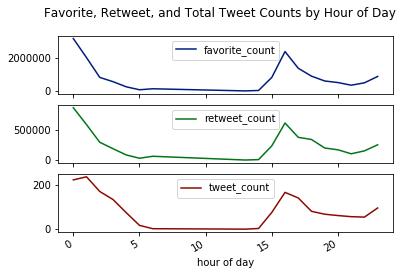

In [7]:
# plot tweet counts per hour in a grid using `subplots=True`
tweet_counts_by_hour.plot(subplots=True, title='Favorite, Retweet, and Total Tweet Counts by Hour of Day');

Looking at the tweet counts summed per hour of day, all the tweet counts follow the same general shape, but at a different scale. As a whole, there seems to be not too many tweets during business hours. The amount of tweets sharply peaks near the close of business and then trails off towards individuals' bedtimes. Suprisingly, there is another peak in the middle of the night.

##### Dog ratings over time

Since time series have been very interesting to look at, dog ratings is next up as it might have something to show in its time series. This time, the visualization will be looking at the average dog rating numerator grouped by month.

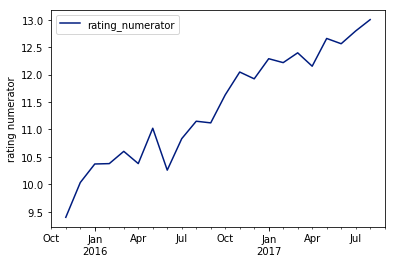

In [8]:
ave_ratings_over_time = tweet_archive_master[['timestamp', 'rating_numerator']].copy().groupby(pd.Grouper(key='timestamp', freq='M')).mean()
ave_ratings_over_time.plot(); plt.xlabel(''); plt.ylabel('rating numerator');

Although the average hasn't changed too much over time (look at the scale on the y-axis), there still has been a steady increase over time. If plotted in a grid with the tweet counts data, the rating increase may correspond to the rise in popularity.

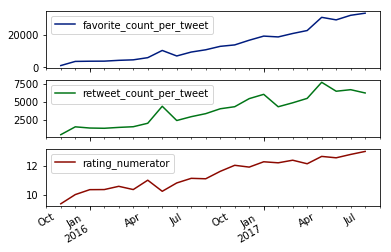

In [9]:
pd.concat([per_tweet_archive_by_month, ave_ratings_over_time], axis=1).plot(subplots=True); plt.xlabel('');

Looking at the trends, the increase in 'rating_numerator' kept pace with the increase of the 'per_tweet' variables but on a lesser scale. Therefore, the increase in rating may be because the tweet account started to develop its character to keep pace with follower expectations as the following grew.

##### Average dog breed popularity

Using the image prediction data, 113 different breeds were identified in pictures, which is too many to look at all at once, so the top 20 based on number of tweets will be chosen to look at since they have each have a larger sample size.

In [10]:
# get top 20 dog breeds by population size
top_20_breeds = tweet_archive_master['dog_breed'].value_counts().index[:20]
# get entries for top 20 breeds
top_20_breed_archive = tweet_archive_master[tweet_archive_master.dog_breed.isin(top_20_breeds)]
# group entries by dog breed
top_20_breed_stats = top_20_breed_archive.groupby('dog_breed').mean()

From the analysis over time, the numerator ratings didn't have too much variation, so that column needs to be pulled out by itself.

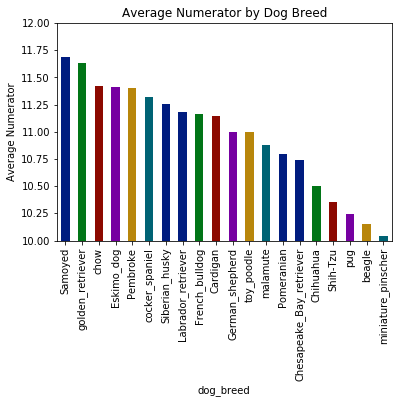

In [11]:
top_20_breed_stats['rating_numerator'].sort_values(ascending=False).plot(kind='bar', ylim=[10,12], title="Average Numerator by Dog Breed");
plt.ylabel('Average Numerator');

There isn't a lot of difference overall in the average numerators of the top 20 breeds, but the average rating starts dropping more sharply after rank 16.

The average 'favorite_count' and 'retweet_count' by breed would be the only other interesting things.

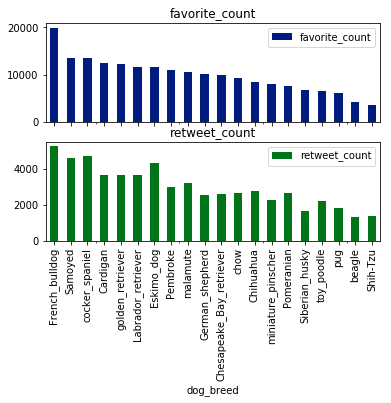

In [12]:
top_20_breed_stats[['favorite_count','retweet_count']].sort_values(by='favorite_count', ascending=False).plot(kind='bar', subplots=True);

Nothing stands out except that 'French_bulldog' is a clear winner in the favorite count visualization.
Looking at favorite count by itself will provide a better comparison.

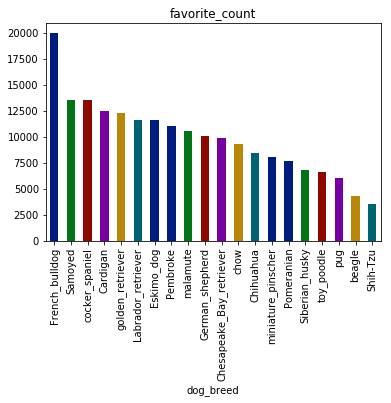

In [13]:
top_20_breed_stats['favorite_count'].sort_values(ascending=False).plot(kind='bar', subplots=True);

Pulling 'favorite_count' out shows that there is a huge jump even between 'French_bulldog' and the next highest average favorite count. 'French_bulldog' is definitely the most liked dog based on average favorite count.

##### Dog stage ratings
The dog stages are cutsy based on jargon for different ages and sizes of puppies. Looking at the ratings, favorite count, and retweet count should show the most preferred dog stage.

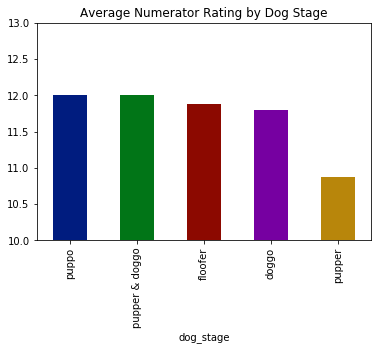

In [14]:
dog_stage_stats = tweet_archive_master[['dog_stage', 'rating_numerator', 'favorite_count', 'retweet_count']].groupby('dog_stage').mean()
dog_stage_stats['rating_numerator'].sort_values(ascending=False).plot(kind='bar', ylim=[10,13], title='Average Numerator Rating by Dog Stage');

Based on the primary rating from the Twitter account, there is no preference by the account for any particular dog stage.

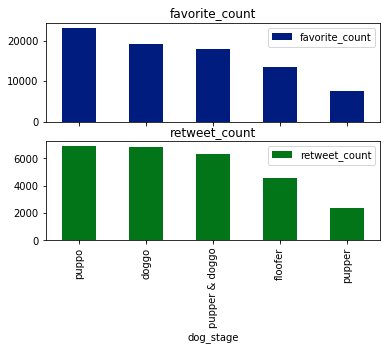

In [15]:
dog_stage_stats[['favorite_count', 'retweet_count']].sort_values(by='favorite_count', ascending=False).plot(kind='bar', subplots=True);

Based on retweets and favorite counts, people seem to like puppos and doggos the most with the combination of pupper & doggo coming in a close third.

### Conclusion

Based on the visual analysis of the WeRateDogs tweet archive, the following were deduced:
* favorites and retweets of WeRateDogs tweets show the popularity growth of the Twitter account
* when the tweet was posted had an impact on the amount of favorites and retweets
* the average numerator rating increased with a similar shape as the favorites and reweets
* French bulldogs had the most favorites amongst the breeds
* Doggos and puppos had the highest favorite and retweet counts with pupper/doggo combos coming in a close third